#**CSIE5732 Computer Vision, NTU, TPE**
[Homework7](http://cv2.csie.ntu.edu.tw/CV/hw2019/hw7.html)


>Deadline : 2022-11-15

> Hello TA, the colab file can be found in the [URL](https://colab.research.google.com/drive/1WKNC0xF6Imz3oO4IM8u4zvyVcEj2OKJ_?usp=sharing)





##Description:
###Write a program which does thinning on a downsampled image (lena.bmp).
###Announcement
*   Downsampling Lena from 512x512 to 64x64:
*   Binarize the benchmark image lena as in HW2, then using 8x8 blocks as a unit, take the topmost-left pixel as the downsampled data.
*   You have to use 4-connected neighborhood detection.
*   You can use any programing language to implement homework, however, you'll get zero point if you just call existing library.

###**FAQ**
*   Q1: 作法要以上課PPT還是這裡提供的PPT為主？
>作業請參考Announcement(此網頁)提供的PPT為主。
*   Q2: 有規定報告的頁數嗎?
>沒有，但建議不要超過4頁。報告內容簡短扼要即可。
*   Q3: 請問之前作業實作過的函式，以後作業可以直接 call 現成函式嗎?
>可以哦，如果是之前作業手刻過的函式，之後用到可以任意 call function.
*   Q4: 投影片第109頁似乎不太正確?
>正確結果請參考外面的動圖。
*   Q5: 結果需要像外面的動圖，還是最後Thinning完成的結果?
>Thinning完成的結果圖就可以了。
*   Q6: 先Binarize還是先Downsample?
>都可以。
*   Q7: Step1 是要用上課投影片的 marked-interior/border-pixel operator，還是使用 Yokoi，來產生 Pair relationship operator 所需要的圖
>照此網頁提供的ppt所寫，用 Yokoi
*   Q8: Padding 有限定使用哪種方式嗎?
>補什麼都可以





##Step1: Load the Dependencies

> This section loads some required libraries used in this notebook: **numpy**, **cv2**

*   [Numpy](https://www.numpy.org/) is an array manipulation library, used for linear algebra, Fourier transform, and random number capabilities.
*   [CV2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.






In [ ]:
import numpy as np
import copy
from past.builtins import xrange
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display

##Step2: read the image

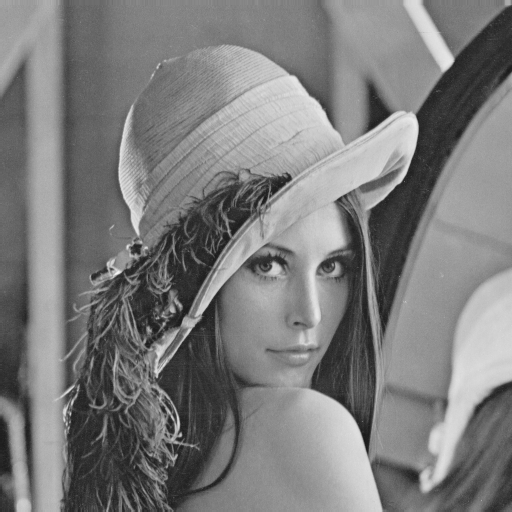

In [ ]:
img = cv2.imread('/content/lena.bmp',0)
cv2_imshow( img )

##Step3: binarize the image according to the threshold value 127
*    for pixel value 000 - 127, set the binarized value as 0
*    for pixel value 128 - 255, set the binarized value as 255

In [ ]:
# binarize the image according to the threshold value thresh
def binarize(img, thresh, maxval):
    binarizedImg = np.zeros(img.shape, dtype=np.int)
    for rowIdx in range(img.shape[0]):
        for colIdx in range(img.shape[1]):
            binarizedImg[rowIdx][colIdx] = maxval if img[rowIdx][colIdx] > thresh else 0
    return binarizedImg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


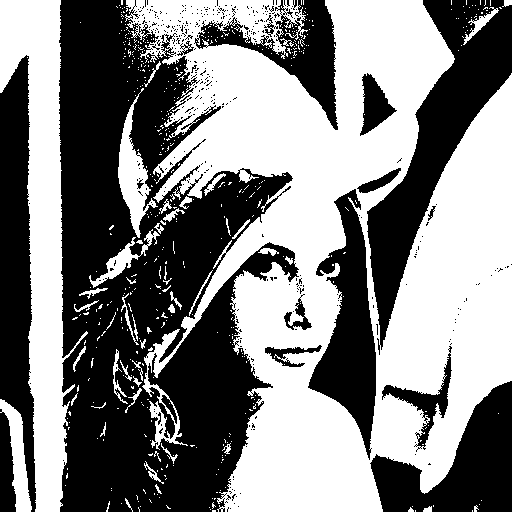

True

In [ ]:
img_binarized = binarize(img, 127, 255)
cv2_imshow( img_binarized )
cv2.imwrite('lena_binarized.bmp', img_binarized)

##Step4: down-sample the image from 512 x 512 to 64 x 64

In [ ]:
def downsampling(img,newshape):
    downsampledImg = np.zeros( newshape, int )
    scale = img.shape[0] // newshape[0]
    for rowIdx in range(downsampledImg.shape[0]):
        for colIdx in range(downsampledImg.shape[1]):
            downsampledImg[rowIdx][colIdx] = img[rowIdx*scale][colIdx*scale]
    return downsampledImg

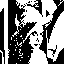

True

In [ ]:
downsampledImg = downsampling(img_binarized,(64,64))
cv2_imshow( downsampledImg )
cv2.imwrite('lena_downsampled.bmp', downsampledImg )

##Step5: define some utility **functions**

### 5-1 indexes_set
this function consider the position of the pixel and remove the indexes of neighrbors whose positions are out of bound
1. we first index the pixels in a 3 x 3 neighborhood

$x_7\;x_2\;x_6\\x_3\;x_0\;x_1\\x_8\;x_4\;x_5$

2. second, we consider four condition when the center pixel $x_0$ is at the boundary of the image.

    1. row index == 0: this means that the pixel locates at the uppermost row of the image; thus the neighbors $x_7\;x_2\;x_6$ do not exist; we remove {7,2,6} from the indexes.
    2. row index == M-1: this means that the pixel locates at the bottommost row of the image; thus the neighbors $x_8\;x_4\;x_5$ do not exist; we remove {8,4,5} from the indexes.
    3. column index == 0: this means that the pixel locates at the leftmost column of the image; thus the neighbors $x_7\;x_3\;x_8$ do not exist; we remove {7,3,8} from the indexes.
    4. column index == N-1: this means that the pixel locates at the rightmost column of the image; thus the neighbors $x_6\;x_1\;x_5$ do not exist; we remove {6,1,5} from the indexes.

In [ ]:
def indexes_set(indexes,M,N,rowIdx,colIdx):
    if rowIdx == 0:
        indexes -= {7,2,6}
    elif rowIdx == M-1:
        indexes -= {8,4,5}
    if colIdx == 0:
        indexes -= {7,3,8}
    elif colIdx == N-1:
        indexes -= {6,1,5}
    return indexes

### 5-2 idx2position
this function transform the subscript of the neighbor $x_i$, i.e. the index i, to the **relative** position to the centered pixel $x_0$.
1. we first index the pixels in a 3 x 3 neighborhood

$x_7\;x_2\;x_6\\x_3\;x_0\;x_1\\x_8\;x_4\;x_5$

2. the relative positions can be found in the following manner.

$(-1,-1)\;(-1,+0)\;(-1,+1)\\(+0,-1)\;(+0,+0)\;(+0,+1)\\(+1,-1)\;(+1,+0)\;(+1,+1)$

3. therefore, we have the following mapping

$ index, i \rightarrow relative\;position\;(\Delta x,\Delta y)\\
0 \rightarrow (+0,+0)\\
1 \rightarrow (+0,+1)\\
2 \rightarrow (-1,+0)\\
3 \rightarrow (+0,-1)\\
4 \rightarrow (+1,+0)\\
5 \rightarrow (+1,+1)\\
6 \rightarrow (-1,+1)\\
7 \rightarrow (-1,-1)\\
8 \rightarrow (+1,-1)$

In [ ]:
def idx2position (index):
    i2p = { 7:(-1,-1), 2:(-1,0), 6:(-1,1), 3:(0,-1), 0:(0,0), 1:(0,1), 8:(1,-1), 4:(1,0), 5:(1,1) }
    return i2p[index]

### 5-3 yokoi_connectivity_number_operator
this is basically what we have done in homework 6.
1. initialize a new numpy array with value -1, indicating as the background.
2. use the formula in section 6.2.5 in "Computer and Robot Vision Volume 1" to define the two primitive functions h and f.
    
    1. function h determines whether a three-pixel corner neighborhood is connected in a particular way 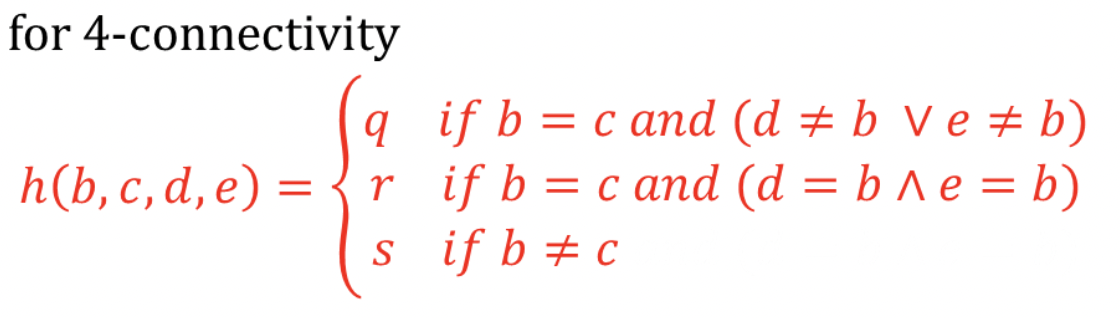
    2. function f counts the number of arguments having a particular value.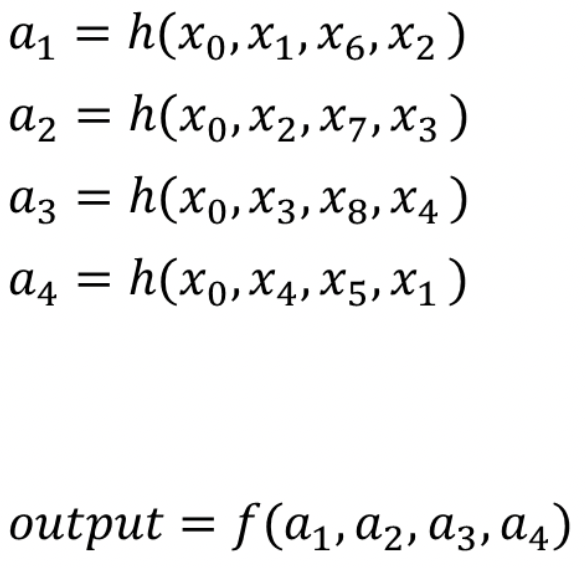
3. return the numpy array yokoi_map whose entry yokoi_map[i][j] records the Yokoi connectivity number of the pixel[i][j]

In [ ]:
def yokoi_connectivity_number_operator(img):
    def h(b, c, d, e):
        if b == c:
            if (d != b or e != b):
                return 'q'
            else:
                return 'r'
        else:
            return 's'

    def f(b, c, d, e):
        if b == 'r' and c == 'r' and d == 'r' and e == 'r':
            return 5
        else:
            ans = 0
            for element in [b, c, d, e]:
                if element == 'q':
                    ans += 1
            return ans

    yokoi_map = np.full(img.shape, -1, dtype=int)

    for rowIdx in range( img.shape[0] ):
        for colIdx in range( img.shape[1] ):
            if img[rowIdx][colIdx] > 0:
                x = [0] * 9
                idxSet = indexes_set( set(i for i in range(8+1) ),img.shape[0],img.shape[1],rowIdx,colIdx)
                for idx in idxSet:
                    dr, dc = idx2position(idx)
                    x[idx] = img[rowIdx+dr][colIdx+dc]
                a1 = h(x[0], x[1], x[6], x[2])
                a2 = h(x[0], x[2], x[7], x[3])
                a3 = h(x[0], x[3], x[8], x[4])
                a4 = h(x[0], x[4], x[5], x[1])
                yokoi_map[rowIdx][colIdx] = f(a1,a2,a3,a4)
    return yokoi_map

In [ ]:
def show_array(arr):
    for i in range( arr.shape[0]):
        for j in range( arr.shape[1] ):
            if arr[i][j] <0:
                print("",end =" ")
            else:
                print(str(arr[i][j]),end =" ")
        print()

In [ ]:
yokoi_map = yokoi_connectivity_number_operator(downsampledImg)
show_array(yokoi_map)

### 5-4 pair_relationship_operator
thie function implements the *pair relationship operator* in section 6.2.7
the pair-relationship operator marks a pixel with the specified label p if the pixel has a specified label l and neighbors enough pixels having a specified label m.
all other pixels it either marks with another specified label or leaves un-modified.
1. initialize a new numpy array with value 0, indicating as the background.
2. use the formula in section 6.2.7 in "Computer and Robot Vision Volume 1" to define the primitive functions h and output.
3. the two-argument function h can recognize whether its first argument has the value of its second argument.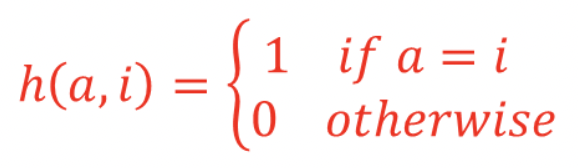

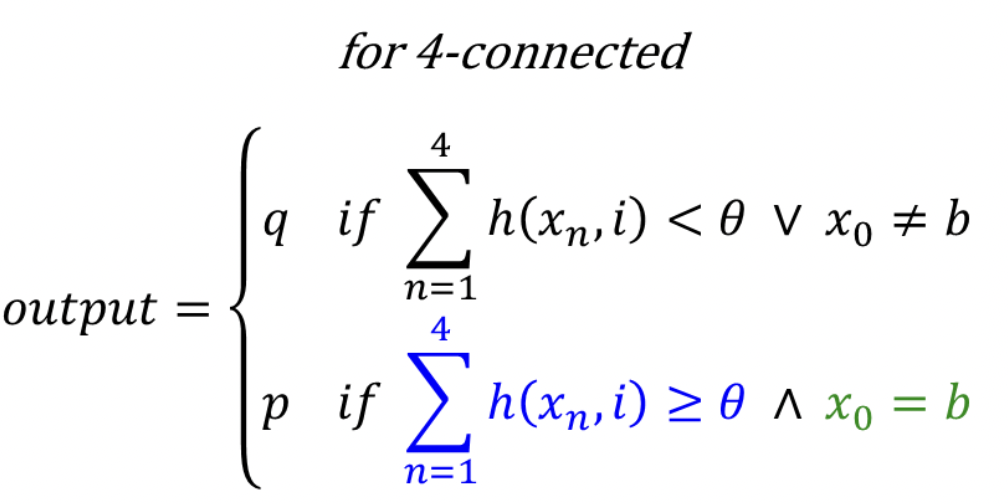


In [ ]:
def pair_relationship_operator(yokoi):
    def h(a, m):
        if a == m:
            return 1
        else:
            return 0
    def f(a_sum, theta):
        if a_sum >= theta:
            return 1 # label p : 1
        else:
            return 2 # label q : 2

    # background pixel: 0
    paired_map = np.zeros(yokoi.shape, np.int)

    for rowIdx in xrange(yokoi.shape[0]):
        for colIdx in xrange(yokoi.shape[1]):
            if yokoi[rowIdx][colIdx] > 0:
                if yokoi[rowIdx][colIdx] == 1:
                    x = [0] * 5
                    idxSet = indexes_set( set(i for i in range(4+1) ),yokoi.shape[0],yokoi.shape[1],rowIdx,colIdx)
                    for idx in idxSet:
                        dr, dc = idx2position(idx)
                        x[idx] = yokoi[rowIdx+dr][colIdx+dc]
                    sum_h = 0
                    for i in range(1,4+1):
                        sum_h += h( x[i], 1 ) # edge : yokoi connct. no. == 1
                    paired_map[rowIdx][colIdx] = f(sum_h, 1)
                else:
                    paired_map[rowIdx][colIdx] = 2 # label q: 2
    return paired_map

### 5-5 connected_shrink_operator
this function implements the connected shrink operator in section 6.2.6
it requires two primitive functions:
 - a primitive functino h that can determine whether the three-pixel corner of a neighborhood is connectedd
 - a five-argument primitive functino f counts the number of arguments having certain values.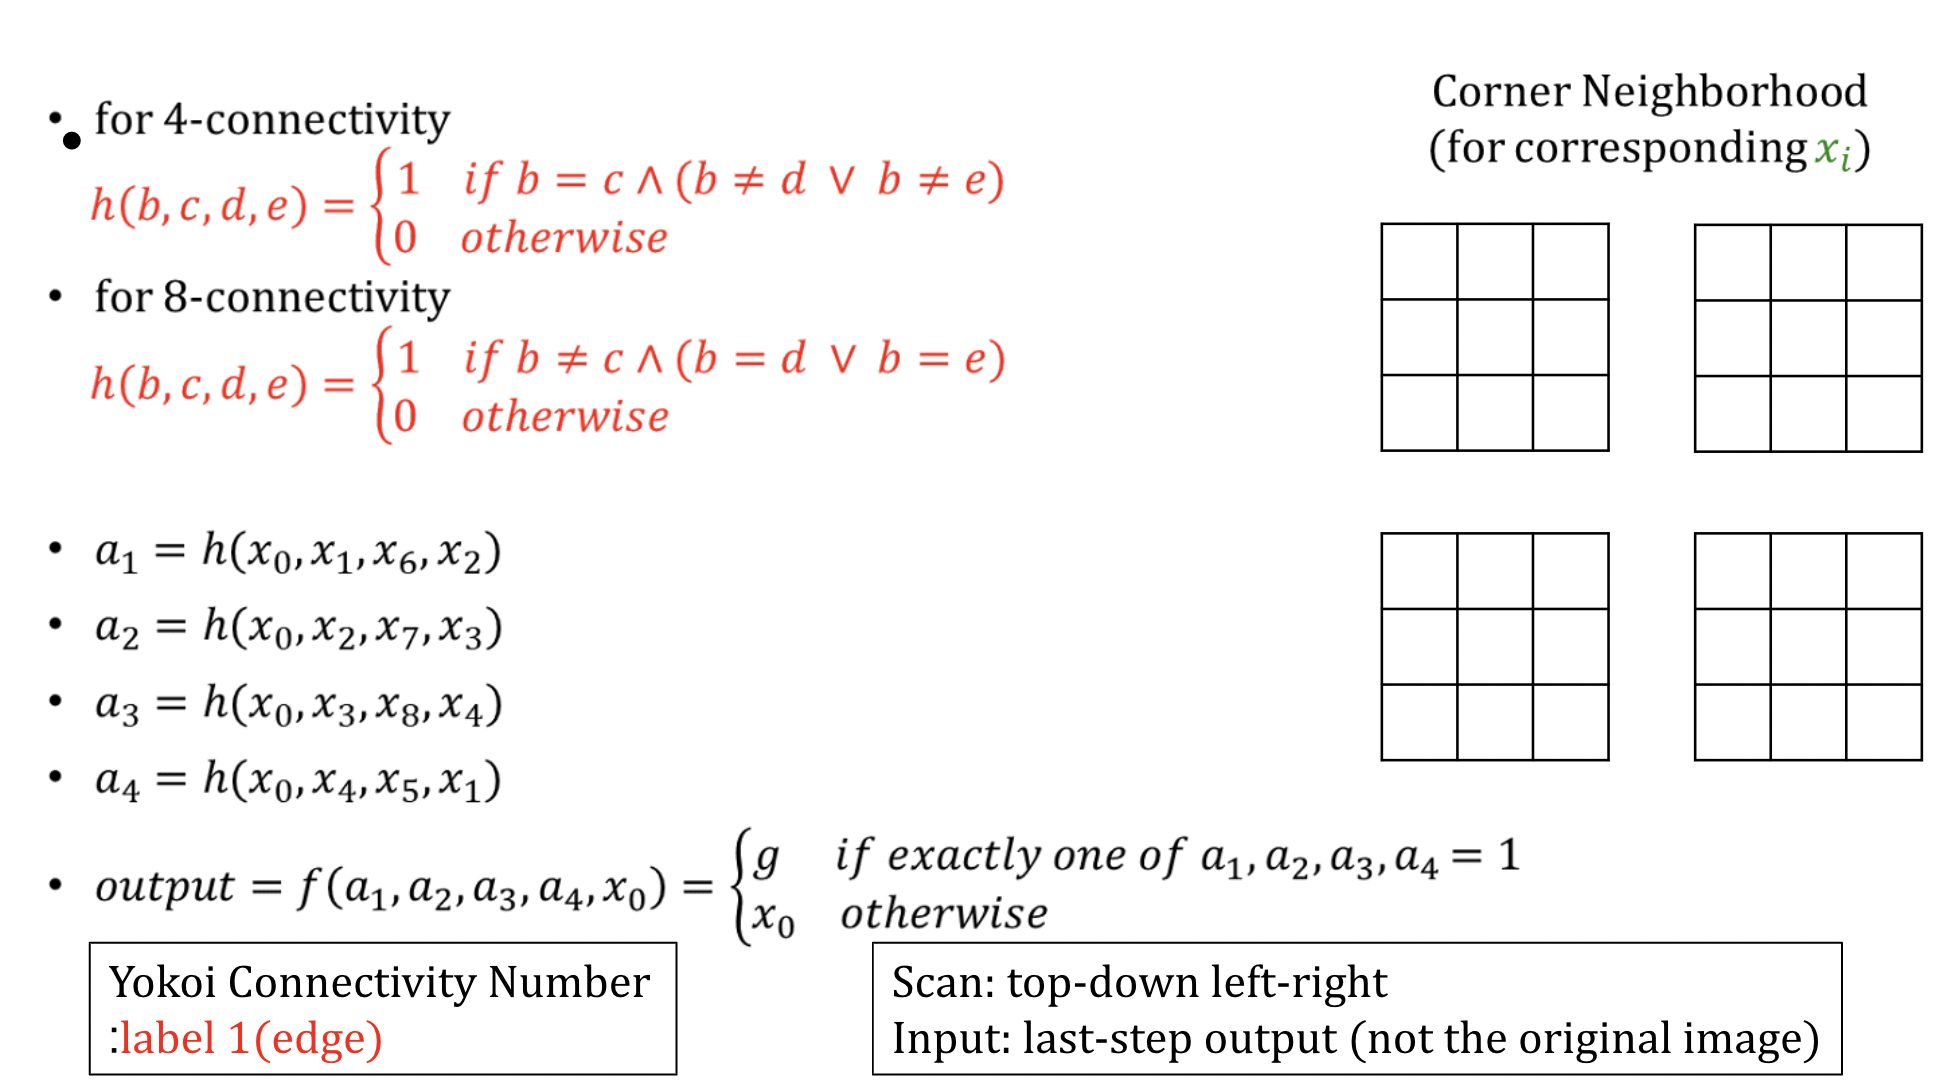

In [ ]:
def connected_shrink_operator(img, marked_img):
    def h(b, c, d, e):
        if b == c and ( d != b or e != b):
            return True
        else:
            return False
    for rowIdx in xrange(img.shape[0]):
        for colIdx in xrange(img.shape[1]):
            # if the label is p, a.k.a. 1
            if marked_img[rowIdx][colIdx] == 1:
                x = [0] * 9
                idxSet = idxSet = indexes_set( set(i for i in range(8+1) ),img.shape[0],img.shape[1],rowIdx,colIdx)
                for idx in idxSet:
                    dr, dc = idx2position(idx)
                    x[idx] = img[rowIdx+dr][colIdx+dc]
                a1 = h(x[0], x[1], x[6], x[2])
                a2 = h(x[0], x[2], x[7], x[3])
                a3 = h(x[0], x[3], x[8], x[4])
                a4 = h(x[0], x[4], x[5], x[1])
                if a1^a2^a3^a4:
                    img[rowIdx][colIdx] = 0

###5-6 create_marked_image
this function implement part 1 in the homework description PDF.
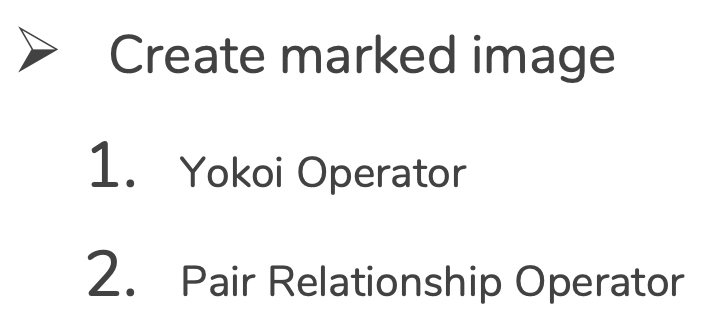

In [ ]:
def create_marked_image(img):
    yokoi_map   = yokoi_connectivity_number_operator(img)
    marked_img  = pair_relationship_operator(yokoi_map)
    return marked_img

###6. thinning operator
1. create marked image
2. Connected Shrink Operator
3. Compare the shrink result with marked image until there is no more changes.

In [ ]:
def thinning_operator(img):
    while True:
        old_img = copy.deepcopy(img)
        marked_img  = create_marked_image(img)
        connected_shrink_operator(img,marked_img)
        if np.sum(img == old_img) == img.shape[0] * img.shape[1]:
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


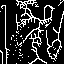

True

In [ ]:
thinning_operator(downsampledImg)
cv2_imshow( downsampledImg )
cv2.imwrite('lena_thinned.bmp', downsampledImg )